In [1]:
import os

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]='-1'

In [3]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report

In [5]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [6]:
import pathlib
# Train Data
data_dir = pathlib.Path('hotdog_data/train/')

hotdog_train = pathlib.Path('hotdog_data/train/hotdog/')
nothotdog_train = pathlib.Path('hotdog_data/train/nothotdog/')

In [7]:
# Count total pictures on the train folder
print(f'Number of Pictures on train folder (HotDog) {len(os.listdir(hotdog_train))}')
# Count total pictures on the test folder
print(f'Number of Pictures on train folder (NotHotDog) {len(os.listdir(nothotdog_train))}')

Number of Pictures on train folder (HotDog) 1500
Number of Pictures on train folder (NotHotDog) 1500


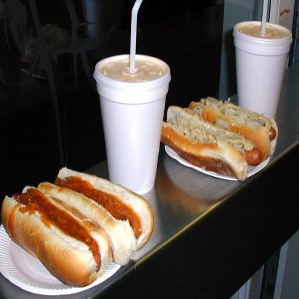

In [8]:
from IPython.display import display # to display images
pil_im = PIL.Image.open('hotdog_data/train/hotdog/102.jpg')
display(pil_im)

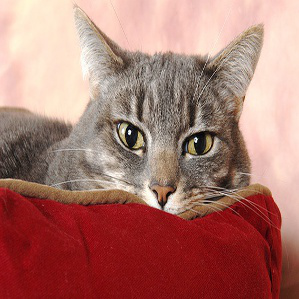

In [9]:
# Display one of the nothotdog images
pil_im = PIL.Image.open('hotdog_data/train/nothotdog/4.jpg')
display(pil_im)

Load images using <strong>image_dataset_from_directory()</strong> utility.

In [10]:
# Define Loader Parameters
batch_size = 32
img_height = 180
img_width = 180

In [11]:
# Create a training Subset
# Use a Validatation split of 20%
#CODE HERE use image_dataset_from_directory()
batch_ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    batch_size=batch_size,
    image_size=(img_height,img_width),
    validation_split=.2,
    subset='training',
    seed=1337)
batch_ds_train

Found 3000 files belonging to 2 classes.
Using 2400 files for training.


<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>

In [12]:
# Create a Validation Subset
# Use a Validatation split of 20%
#CODE HERE use image_dataset_from_directory()
batch_ds_val = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    batch_size=batch_size,
    image_size=(img_height,img_width),
    validation_split=.2,
    subset='validation',
    seed=1337)
batch_ds_val

Found 3000 files belonging to 2 classes.
Using 600 files for validation.


<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>

In [14]:
# Print class names for the training subset
#CODE HERE
batch_ds_train.class_names

['hotdog', 'nothotdog']

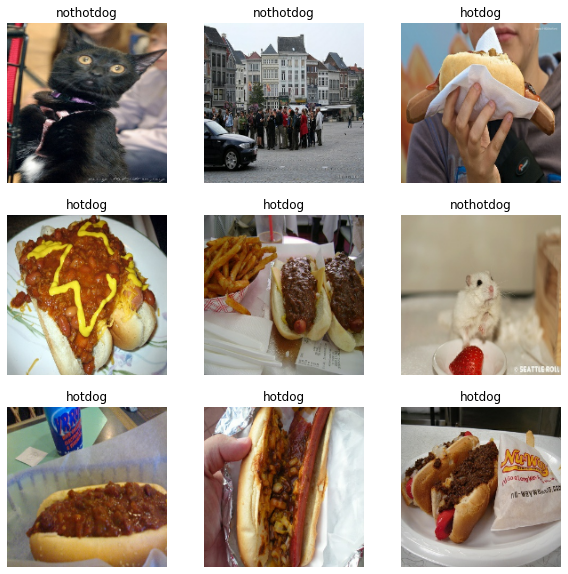

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in batch_ds_train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(batch_ds_train.class_names[labels[i]])
    plt.axis("off")

In [16]:
# Configure Dataset Performance
AUTOTUNE = tf.data.AUTOTUNE

batch_ds_train = batch_ds_train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
batch_ds_val = batch_ds_val.cache().prefetch(buffer_size=AUTOTUNE)

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, you will standardize values to be in the [0, 1] range by using a Rescaling layer.

In [17]:
# Standardize the data
# Create a normalization Layer
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)


In [18]:
# Apply normalization layer to the dataset by calling map.
# Hint: lambda function
normalized_ds = batch_ds_train.map(lambda x, y: (normalization_layer(x), y))
display(type(normalized_ds))
image_batch, labels_batch = next(iter(normalized_ds))

first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


tensorflow.python.data.ops.dataset_ops.MapDataset

0.0 1.0


In [19]:
# Create the model
num_classes = 2

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [20]:
# Compile the mode
# use the adam optimizer
# for loses uses losses.SparseCategoricalCrossentropy 
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


In [21]:
# Model Summary
# Depending on yout model it can be something different
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [22]:
# Train Model
# CODE HERE
model.fit(
    batch_ds_train,
    validation_data=batch_ds_val,
    epochs=10,
    use_multiprocessing=True,
    verbose=1
)

Epoch 1/10
75/75 [==============================] - 24s 311ms/step - loss: 0.6629 - accuracy: 0.6092 - val_loss: 0.5851 - val_accuracy: 0.7000
Epoch 2/10
75/75 [==============================] - 22s 298ms/step - loss: 0.5812 - accuracy: 0.6913 - val_loss: 0.5576 - val_accuracy: 0.6933
Epoch 3/10
75/75 [==============================] - 21s 286ms/step - loss: 0.5150 - accuracy: 0.7408 - val_loss: 0.5578 - val_accuracy: 0.7167
Epoch 4/10
75/75 [==============================] - 21s 286ms/step - loss: 0.4588 - accuracy: 0.7846 - val_loss: 0.6334 - val_accuracy: 0.6467
Epoch 5/10
75/75 [==============================] - 22s 287ms/step - loss: 0.4007 - accuracy: 0.8225 - val_loss: 0.6376 - val_accuracy: 0.7100
Epoch 6/10
75/75 [==============================] - 22s 288ms/step - loss: 0.3082 - accuracy: 0.8625 - val_loss: 0.8490 - val_accuracy: 0.6283
Epoch 7/10
75/75 [==============================] - 22s 290ms/step - loss: 0.2267 - accuracy: 0.9112 - val_loss: 0.8363 - val_accuracy: 0.6950

In [23]:
# Saving Hotdog Model
model.save('hotdog_model')

INFO:tensorflow:Assets written to: hotdog_model\assets


In [24]:
model_loaded = keras.models.load_model('hotdog_model')
model_loaded

In [25]:
model.history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

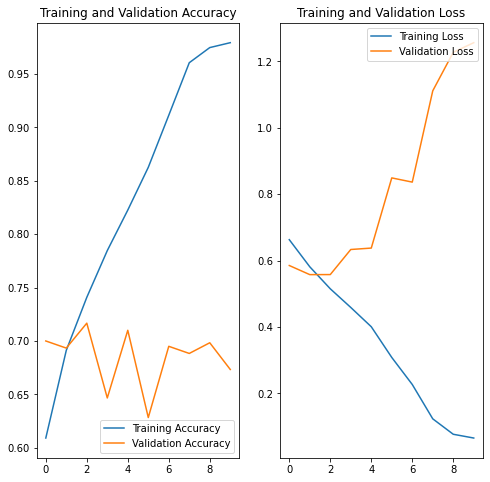

In [26]:
# Visaulize training loss and validation accuracy
# CODE HERE
acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']

loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<strong>Is your model overfitted?</strong>

In [28]:
# If so, consider Dropout
# It is an overfitted model.
model2 = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [29]:
# Compile and train the model
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model2.fit(
    batch_ds_train,
    validation_data=batch_ds_val,
    epochs=10,
    verbose=1
)

Epoch 1/10
75/75 [==============================] - 22s 293ms/step - loss: 0.6717 - accuracy: 0.6054 - val_loss: 0.6464 - val_accuracy: 0.6583
Epoch 2/10
75/75 [==============================] - 22s 290ms/step - loss: 0.5954 - accuracy: 0.6908 - val_loss: 0.5738 - val_accuracy: 0.6817
Epoch 3/10
75/75 [==============================] - 22s 293ms/step - loss: 0.5392 - accuracy: 0.7396 - val_loss: 0.6015 - val_accuracy: 0.6767
Epoch 4/10
75/75 [==============================] - 22s 289ms/step - loss: 0.4961 - accuracy: 0.7621 - val_loss: 0.5663 - val_accuracy: 0.7017
Epoch 5/10
75/75 [==============================] - 22s 289ms/step - loss: 0.4292 - accuracy: 0.7971 - val_loss: 0.5875 - val_accuracy: 0.7050
Epoch 6/10
75/75 [==============================] - 22s 294ms/step - loss: 0.3407 - accuracy: 0.8425 - val_loss: 0.6320 - val_accuracy: 0.6900
Epoch 7/10
75/75 [==============================] - 22s 291ms/step - loss: 0.2495 - accuracy: 0.8983 - val_loss: 0.7481 - val_accuracy: 0.7067

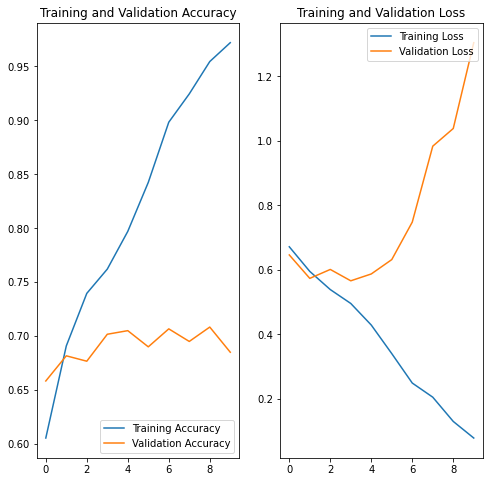

In [30]:
# Visualize your new results
acc = model2.history.history['accuracy']
val_acc = model2.history.history['val_accuracy']

loss = model2.history.history['loss']
val_loss = model2.history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [31]:
model2.save('model2')

INFO:tensorflow:Assets written to: model2\assets


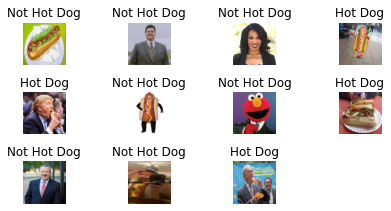

In [32]:
# Predict on New Data
import numpy as np
from keras.preprocessing import image
image_urls = ['fun_data/.jpg']

import glob
image_urls = glob.glob('fun_data/*')

loaded_images = []
test_images = []

for temp in image_urls:
    loaded_images.append(image.load_img(temp,target_size = (180,180)))
    loaded_image = image.load_img(temp,target_size = (180,180))
    test_images.append(np.expand_dims(image.img_to_array(loaded_image), axis = 0))

results = []
for temp in test_images:
    results.append(model2.predict(temp))

for index, temp in enumerate(results):
    if temp[0][0] > 0:
         pred = 'Hot Dog'
    else:
         pred = 'Not Hot Dog'
    ax = plt.subplot(4,4,index +1)
    plt.imshow(loaded_images[index])
    plt.title(pred)
    plt.axis('off')
    plt.tight_layout()

        
#url = 'hotdog_data/train/hotdog/33.jpg'
#loaded_image = image.load_img(url, target_size = (180, 180))
#test_image = np.expand_dims(image.img_to_array(loaded_image), axis = 0)
#result = model2.predict(test_image)